#**Objective:** Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of new headlines.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



####Importing the Python Liberaries to be used

In [2]:
!pip install pmdarima
!pip install --upgrade pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime

#To import the dataset of a related stock from a particular link
import pandas_datareader.data as pdr
import yfinance as yf

#For evading warnings
import warnings
warnings.filterwarnings('ignore')

#For Numerical Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
#from statsmodels.tsa.statespace.sarimax import SARIMAX

#For Textual(Sentiment) Analysis
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Predicting Scores of Different Models
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

#for scaling different Features
from sklearn.preprocessing import MinMaxScaler

#Different Models to evaluate
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import lightgbm 
import xgboost

###Downloading and Importing the necessary Datasets

In [5]:
#Downloading SENSEX Stock data from the yahoo finance website for a specific duration
yf.pdr_override()
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.today()
stock = pdr.get_data_yahoo('^BSESN', start, end)

[*********************100%***********************]  1 of 1 completed


In [6]:
#converting the stock_data file to CSV file
stock.to_csv('Stock_info.csv')

In [7]:
#importing the News dataset
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Predictor/NewsHeadlines.csv')

###Pre-Processing and Data Cleaning

In [8]:
stock.sample(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-08-09,18141.109375,18309.250000,18139.900391,18287.500000,18287.500000,11000
2017-03-01,28849.039062,29029.169922,28824.169922,28984.490234,28984.490234,14600
2017-02-28,28825.189453,28876.539062,28721.119141,28743.320312,28743.320312,10700
2022-10-19,59196.960938,59399.691406,58961.769531,59107.191406,59107.191406,6800
2014-10-17,25950.000000,26248.539062,25910.769531,26108.529297,26108.529297,9400
2022-09-01,58710.531250,59309.789062,58522.570312,58766.589844,58766.589844,19200
2020-02-05,40921.710938,41177.000000,40703.320312,41142.660156,41142.660156,13900
2021-07-29,52693.531250,52777.179688,52561.390625,52653.070312,52653.070312,8800
2010-09-24,19836.429688,20071.750000,19833.519531,20045.179688,20045.179688,17400


In [9]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3303 entries, 2010-01-04 to 2023-06-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3303 non-null   float64
 1   High       3303 non-null   float64
 2   Low        3303 non-null   float64
 3   Close      3303 non-null   float64
 4   Adj Close  3303 non-null   float64
 5   Volume     3303 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 180.6 KB


**No NULL Entries** in the **stock** dataframe.


In [10]:
# Convert date that is the index of the dataframe to one of it's columns
stock.reset_index(inplace=True)

In [11]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3303 entries, 0 to 3302
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3303 non-null   datetime64[ns]
 1   Open       3303 non-null   float64       
 2   High       3303 non-null   float64       
 3   Low        3303 non-null   float64       
 4   Close      3303 non-null   float64       
 5   Adj Close  3303 non-null   float64       
 6   Volume     3303 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 180.8 KB


In [12]:
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,17473.449219,17582.839844,17378.380859,17558.730469,17558.730469,28200
1,2010-01-05,17555.769531,17729.779297,17555.769531,17686.240234,17686.240234,27000
2,2010-01-06,17719.470703,17790.330078,17636.710938,17701.130859,17701.130859,21400
3,2010-01-07,17701.970703,17733.339844,17566.539062,17615.720703,17615.720703,18000
4,2010-01-08,17603.869141,17658.119141,17508.960938,17540.289062,17540.289062,17200


In [13]:
news.sample(10)

,publish_date,headline_category,headline_text
1323025,20120307,city.gurgaon,No legal immunity for govt servant in criminal...
3511990,20210626,world.europe,Greek migrant traffickers arrested in Italy-bo...
2251581,20151031,city.pune,Bus contractors threaten to go on strike again
1293775,20120125,city.nagpur,Court rejects Suretech hospital plea
1557378,20130208,city.pune,Cash; jewellery worth Rs 6.5L stolen from cars
572415,20080505,city.bengaluru,Speeding car kills 1; injures 8 in city
2622082,20170414,city.delhi,Delhi HC's first woman chief justice retires
3040550,20181205,city.mumbai,Test pegging rape survivor's age is valid proo...
3243112,20200104,city.visakhapatnam,Edu dept shifts to e-grievance system
2318183,20160204,city.thane,City to face water cuts on weekends


In [14]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


In [15]:
news['headline_category'].unique()

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'sports.football.euro-2021', 'business.markets.ipo',
       'sports.tokyo-olympics.india-in-tokyo'], dtype=object)

In [16]:
# Total unique headlines
news['headline_category'].unique().shape

(1041,)

In [17]:
# checking how many unique main headline categories are there
news['category'] = news['headline_category'].str.split('.',expand = True)[0]

In [18]:
#installing Sweetiz library for data visualization
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 52.6 MB/s eta 0:00:00


####Textual Analysis

                                             |          | [  0%]   00:00 -> (? left)


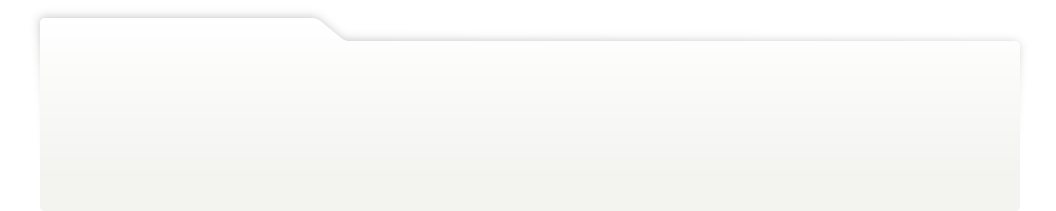
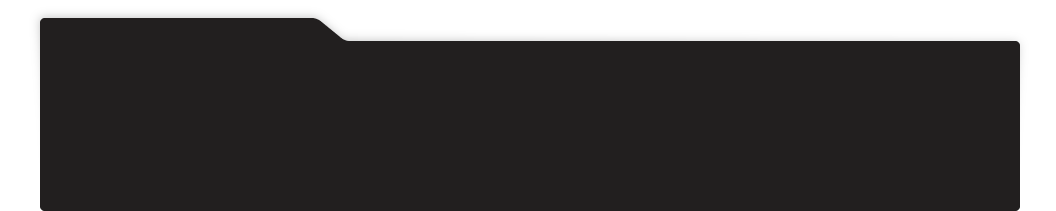
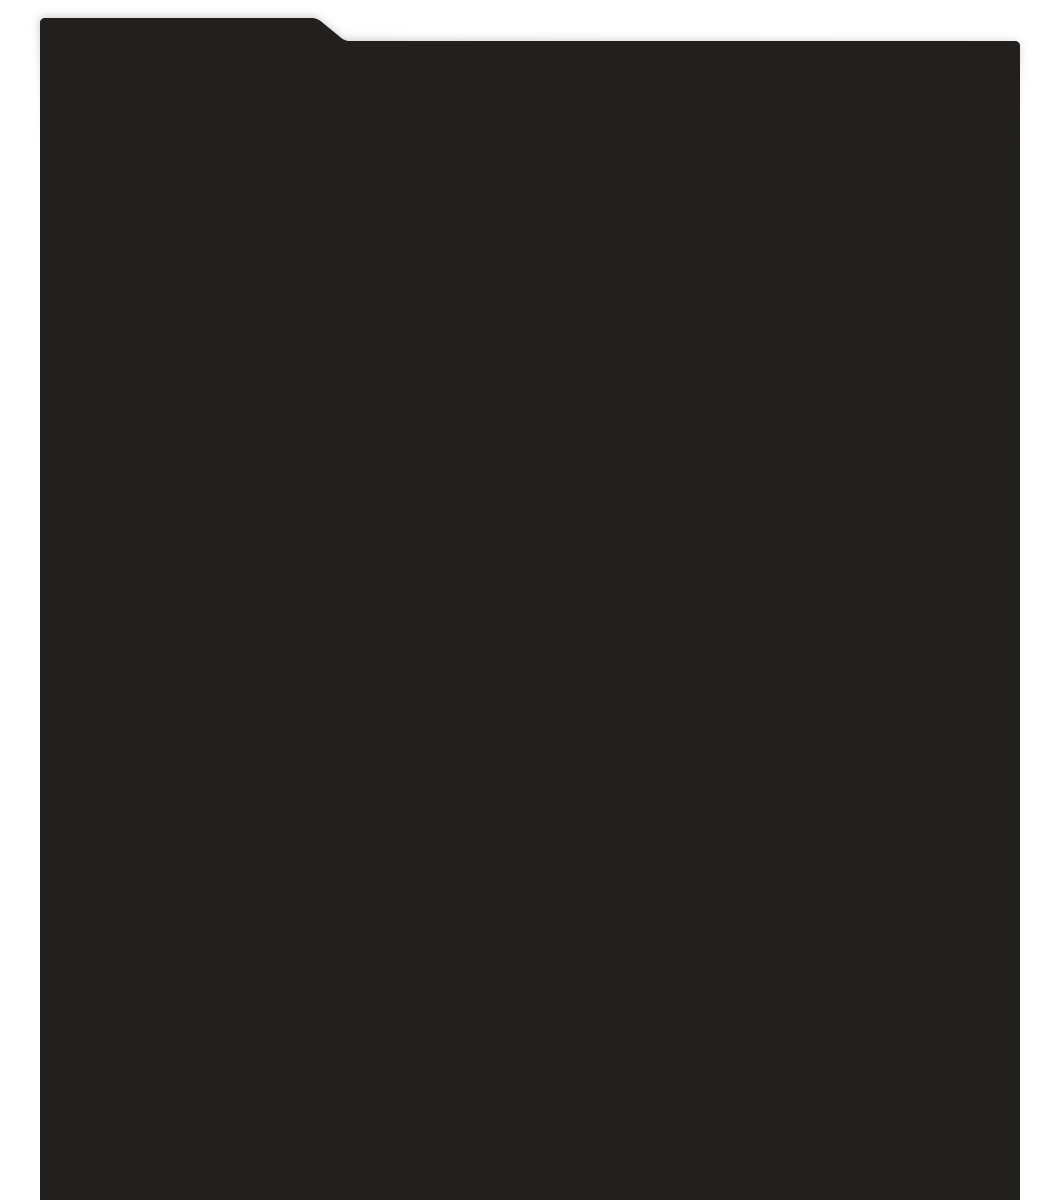
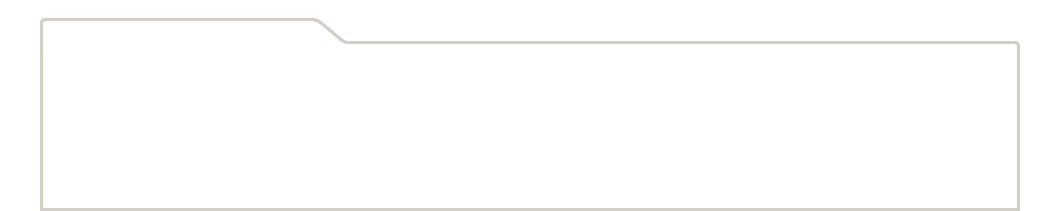
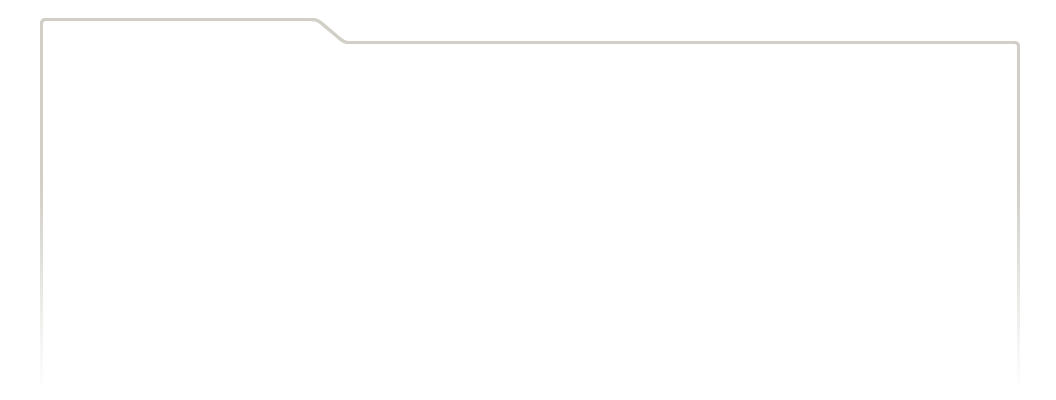
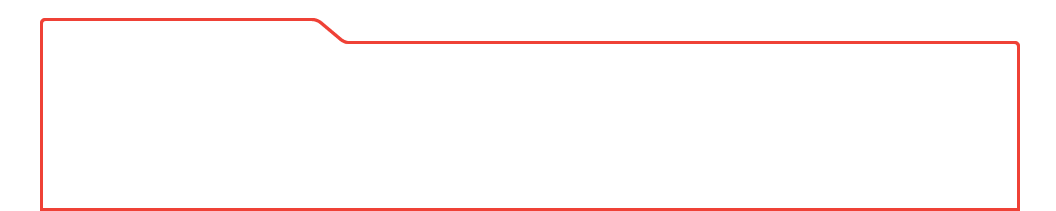
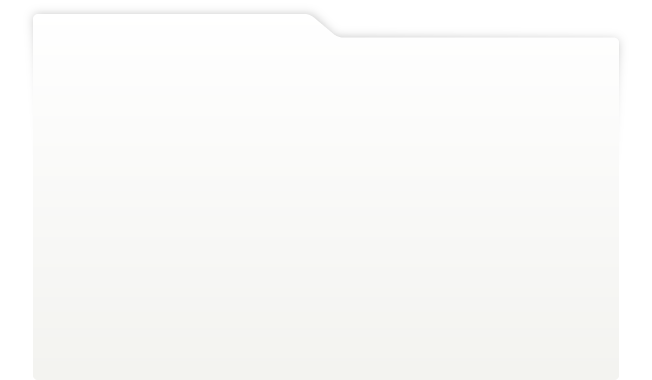
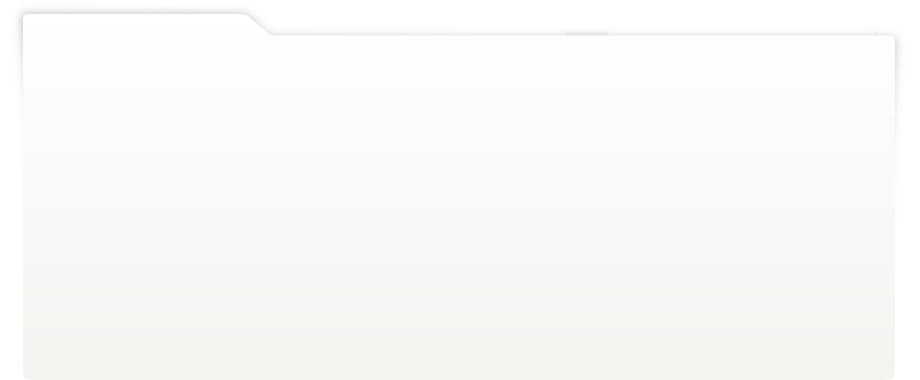
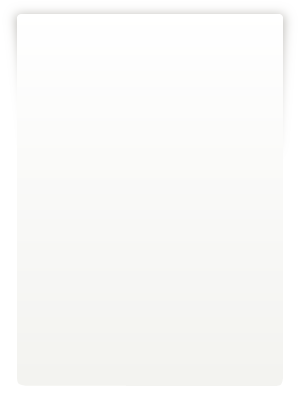
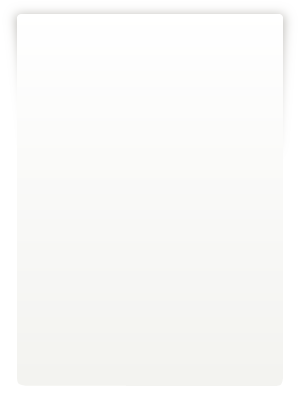
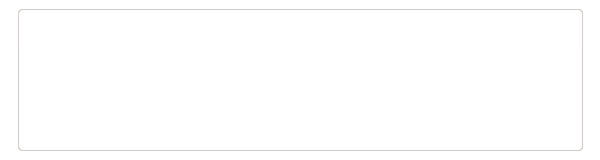
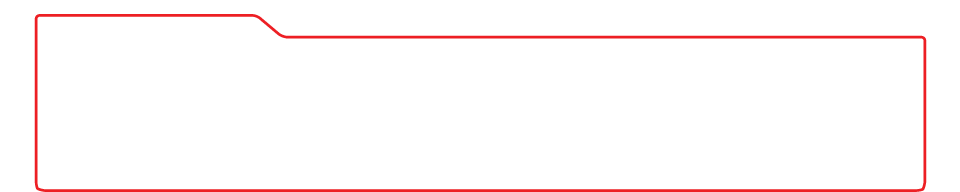
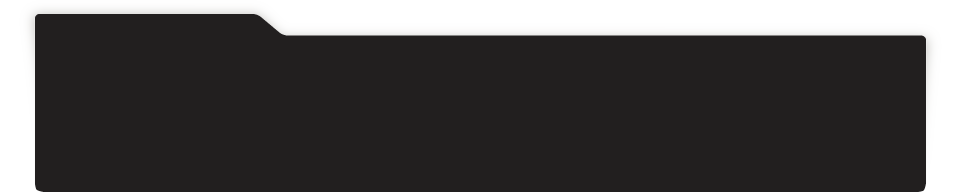
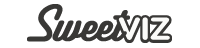
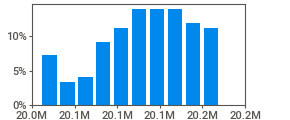
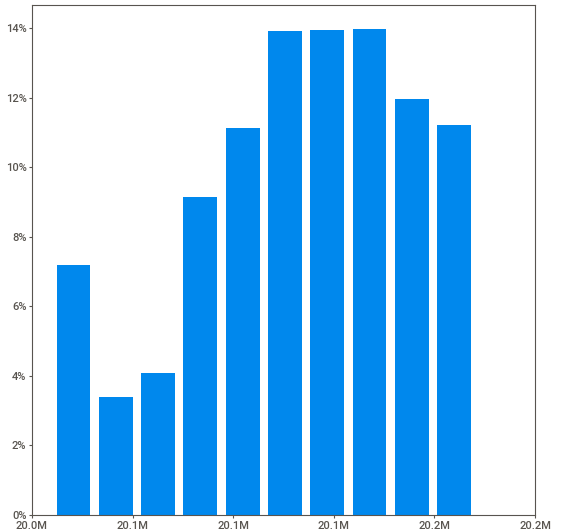
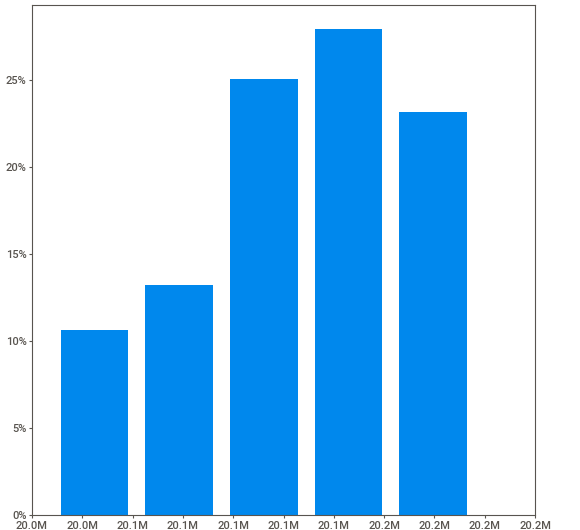
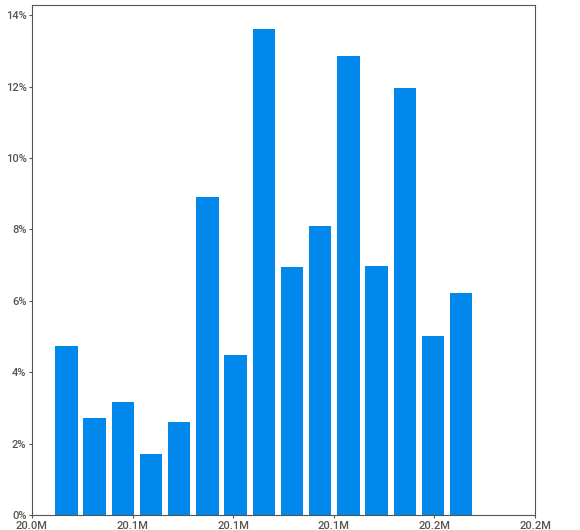
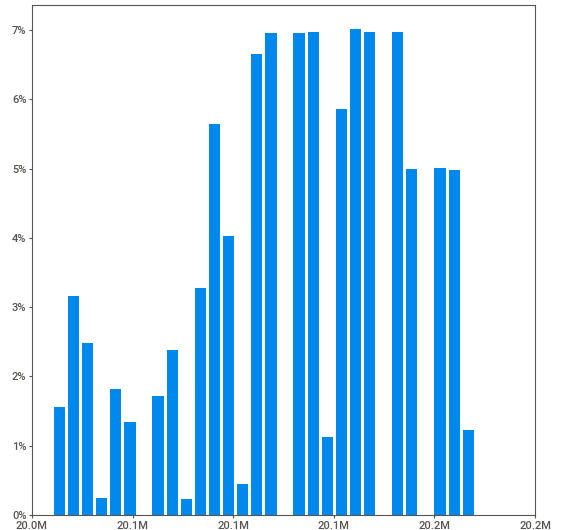
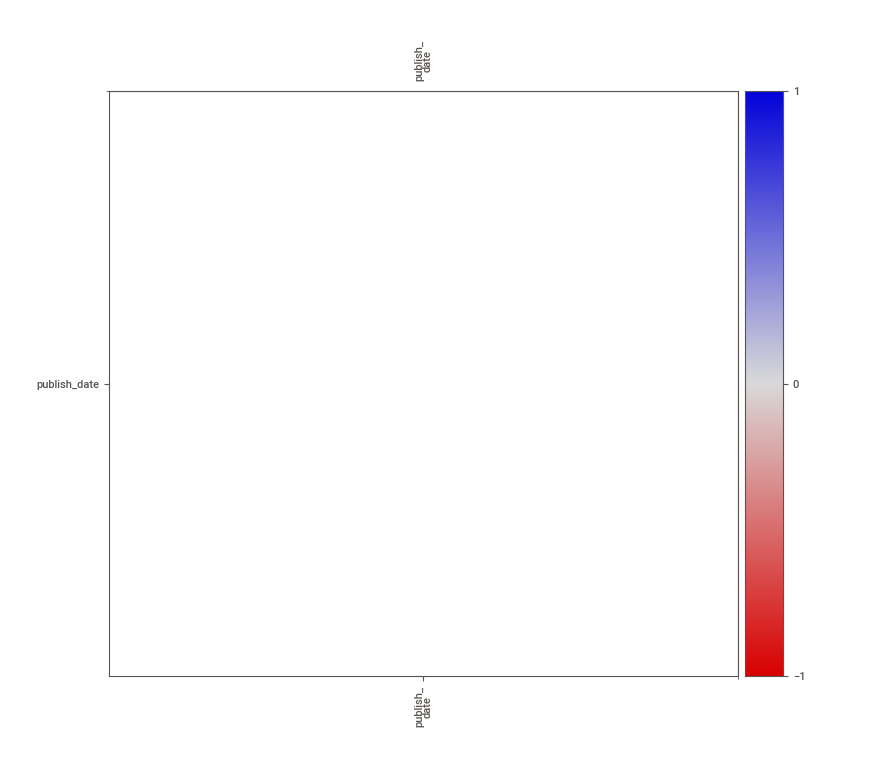
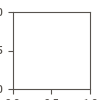

In [19]:
import sweetviz
autoEDA = sweetviz.analyze(news)
autoEDA.show_notebook()

In [20]:
#Renaming the column 'headline_text'
news.rename(columns={'headline_text':'News'}, inplace=True)

In [21]:
#After checking the info of dataframe, the datatype of date not date(int and object)
Date=[]
for date_str in news['publish_date']:
  date_obj = datetime.datetime.strptime(str(date_str), '%Y%m%d').date()
  Date.append(date_obj)
news['Date'] = Date

In [22]:
# Changing type of 'Date' from object to datetime
news['Date']=pd.to_datetime(news['Date'])

In [23]:
#As we can see 'headline_category' and 'category' has no specific relevance and won't effect the end analysis
#Removing these above mentioned columns and publish_date
news.drop(columns=['headline_category','category','publish_date'],inplace=True)

In [24]:
#Checking no. of repeated/duplicated values in news
news.duplicated().sum()

162098

In [25]:
#Let's delete all the repeated news
news.drop_duplicates(inplace=True)

In [26]:
#Let's check if the respective changes have been made
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3488872 entries, 0 to 3650966
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   News    object        
 1   Date    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 79.9+ MB


In [27]:
#now we have to remove all the special characters
def SpecialChars(text):
    final_text=" "
    for i in text:
        if i.isalnum()  or i==' ':
            final_text= final_text+i
        else:
            final_text=final_text + " "
    return final_text.strip()

In [28]:
news_df=news
news_df['News']=news_df['News'].apply(SpecialChars)

In [29]:
news_df.head()

,News,Date
0,Status quo will not be disturbed at Ayodhya s...,2001-01-02
1,Fissures in Hurriyat over Pak visit,2001-01-02
2,America s unwanted heading for India,2001-01-02
3,For bigwigs it is destination Goa,2001-01-02
4,Extra buses to clear tourist traffic,2001-01-02


In [30]:
# Combining different types of News on a single date
news_df['News']=news_df.groupby(['Date']).transform(lambda x: " ".join(x))

In [31]:
news_df

,News,Date
0,Status quo will not be disturbed at Ayodhya s...,2001-01-02
1,Status quo will not be disturbed at Ayodhya s...,2001-01-02
2,Status quo will not be disturbed at Ayodhya s...,2001-01-02
3,Status quo will not be disturbed at Ayodhya s...,2001-01-02
4,Status quo will not be disturbed at Ayodhya s...,2001-01-02
...,...,...
3650960,Shashank goes back to coastal Karnataka and Mo...,2022-03-31
3650961,Shashank goes back to coastal Karnataka and Mo...,2022-03-31
3650962,Shashank goes back to coastal Karnataka and Mo...,2022-03-31
3650965,Shashank goes back to coastal Karnataka and Mo...,2022-03-31


In [32]:
news_df.drop_duplicates(inplace=True)
news_df.reset_index(inplace=True,drop=True)

In [33]:
#Finding the Subjectivity and Polarity of a particular day by assessing the news
def Subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def Polarity(text):
  return TextBlob(text).sentiment.polarity

In [34]:
#Adding them to the news_df dataframe
news_df['Subjectivity']=news_df['News'].apply(Subjectivity)
news_df['Polarity']=news_df['News'].apply(Polarity)

<Axes: >

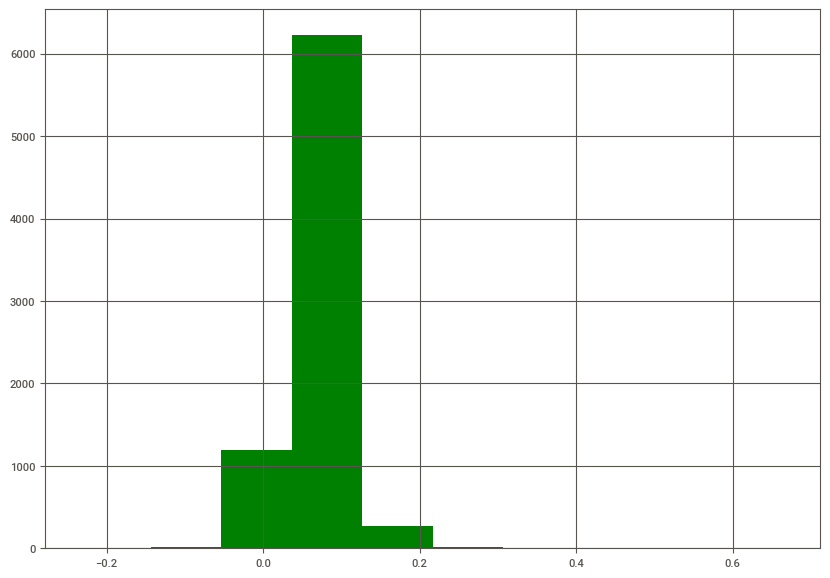

In [35]:
plt.figure(figsize=(10,7))
news_df['Polarity'].hist(color='green')

<Axes: >

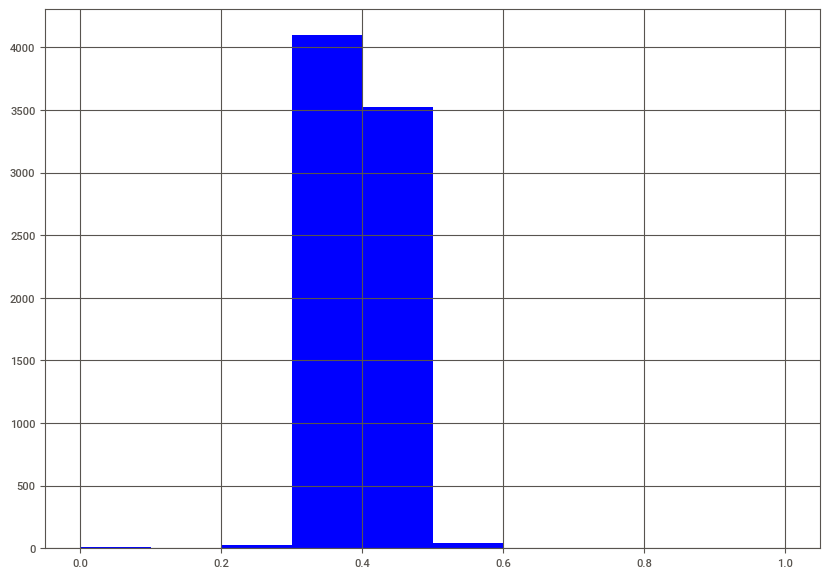

In [36]:
plt.figure(figsize=(10,7))
news_df['Subjectivity'].hist(color='blue')

In [37]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [38]:
#Adding all the sentiment scores to our dataframe news_df
sia = SentimentIntensityAnalyzer()

news_df['Compound'] = [sia.polarity_scores(v)['compound'] for v in news_df['News']]
news_df['Negative'] = [sia.polarity_scores(v)['neg'] for v in news_df['News']]
news_df['Neutral'] = [sia.polarity_scores(v)['neu'] for v in news_df['News']]
news_df['Positive'] = [sia.polarity_scores(v)['pos'] for v in news_df['News']]
news_df

,News,Date,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,Status quo will not be disturbed at Ayodhya s...,2001-01-02,0.298684,0.180702,-0.9839,0.141,0.792,0.068
1,Powerless north India gropes in the dark Think...,2001-01-03,0.392857,0.089286,-0.8910,0.154,0.739,0.107
2,The string that pulled Stephen Hawking to Indi...,2001-01-04,0.478086,0.089802,0.9178,0.102,0.784,0.114
3,Light combat craft takes India into club class...,2001-01-05,0.470967,0.260138,0.9753,0.127,0.690,0.183
4,Light combat craft takes India into club class...,2001-01-06,0.464935,0.219481,-0.8625,0.227,0.653,0.119
...,...,...,...,...,...,...,...,...
7712,Playing a dead man in Body God meant sitting i...,2022-03-27,0.362690,0.033627,-0.9999,0.157,0.762,0.081
7713,As fashion becomes democratic demand for styl...,2022-03-28,0.372774,0.060228,-0.9999,0.161,0.740,0.100
7714,Bobby Deol Like my dad I hope to be working ...,2022-03-29,0.399341,0.091038,-0.9999,0.161,0.755,0.084
7715,I will not give in to trends Dossmode The tim...,2022-03-30,0.335133,0.037703,-0.9999,0.159,0.767,0.074


####Numerical Analysis

                                             |          | [  0%]   00:00 -> (? left)


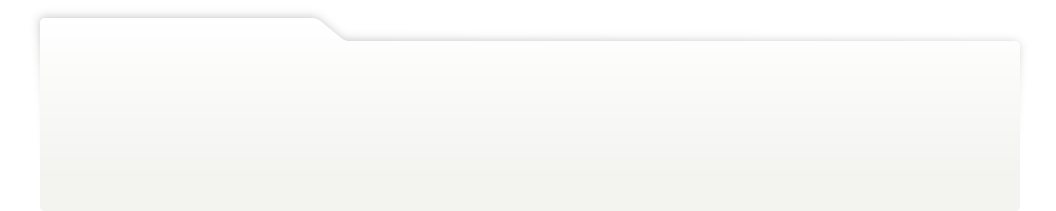
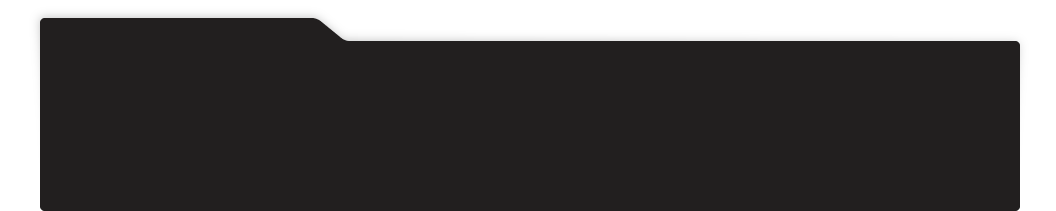
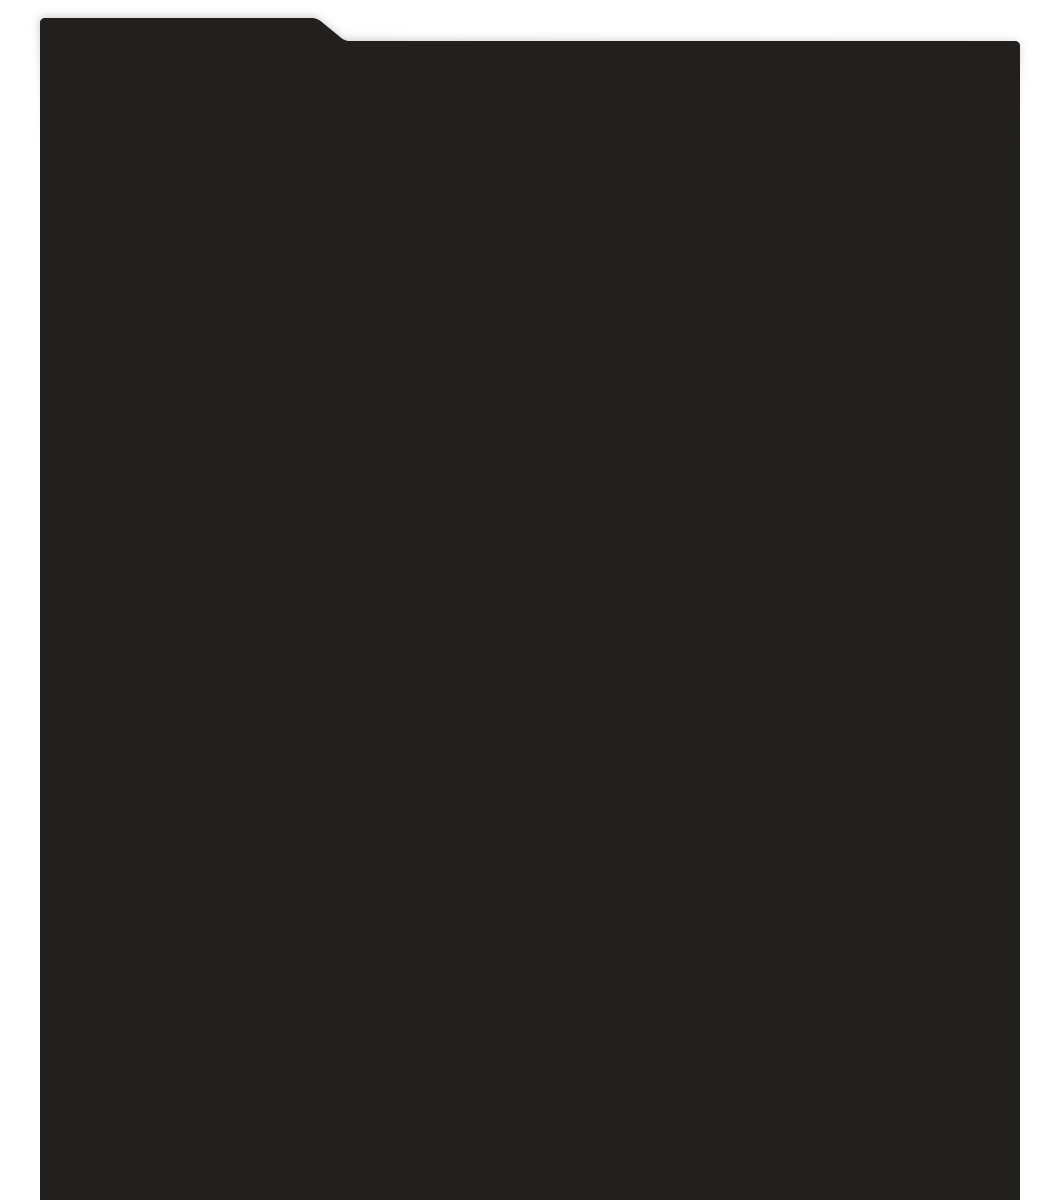
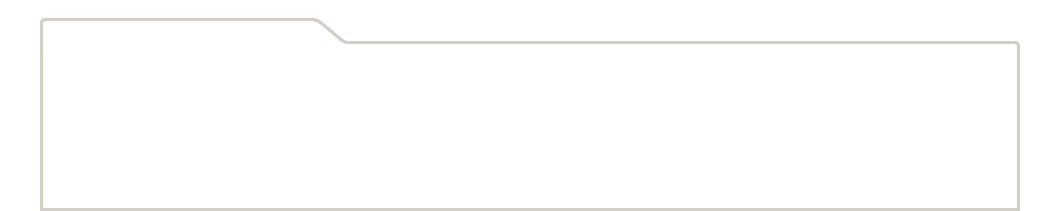
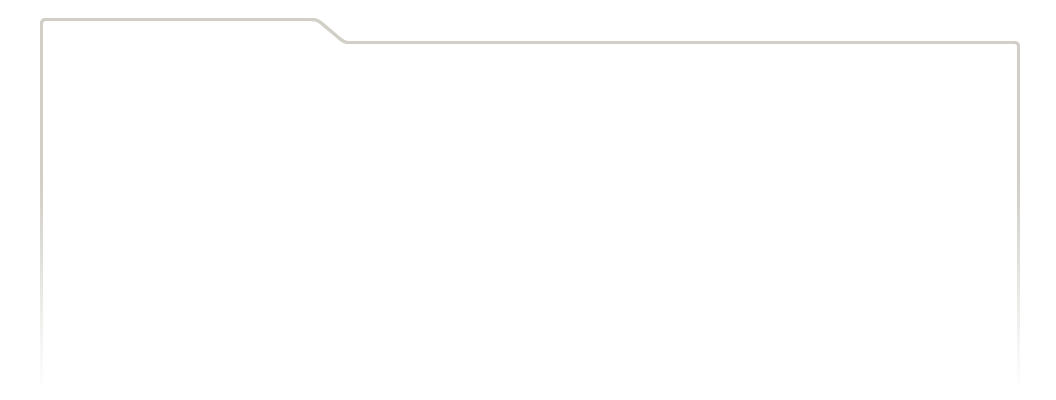
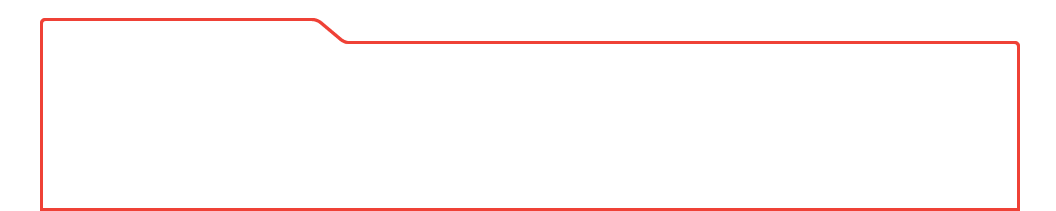
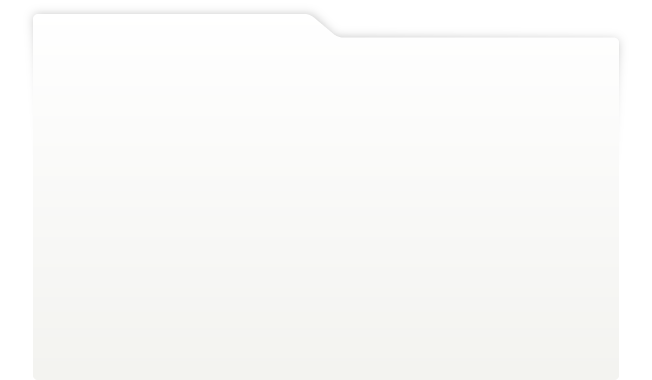
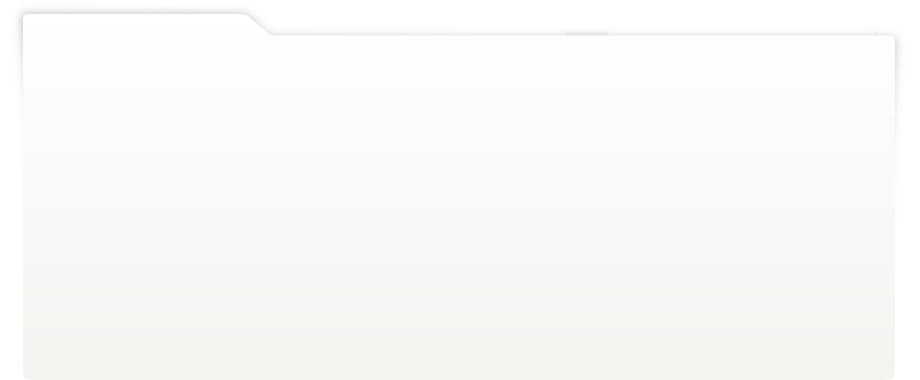
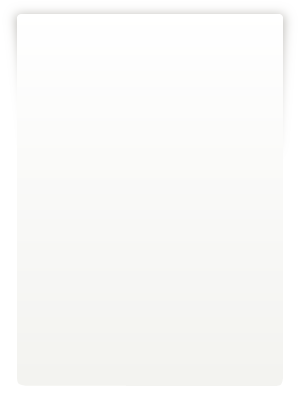
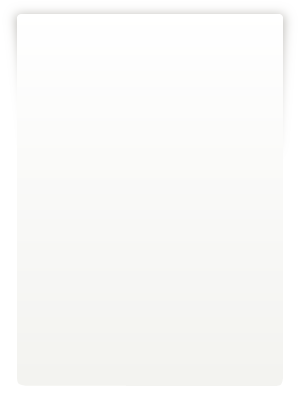
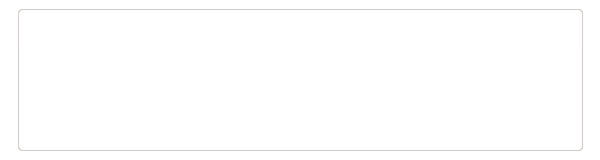
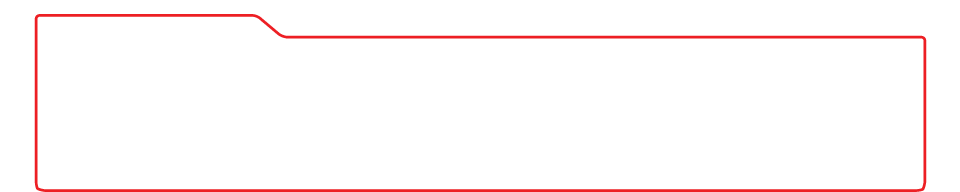
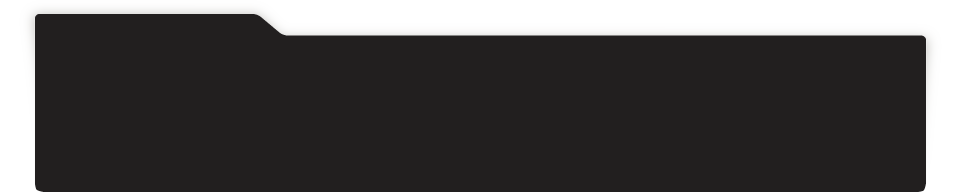
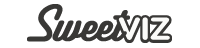
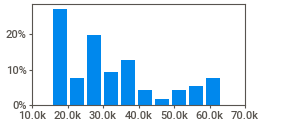
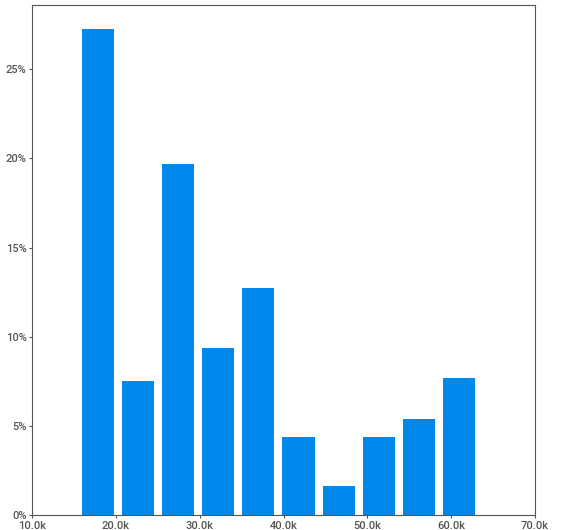
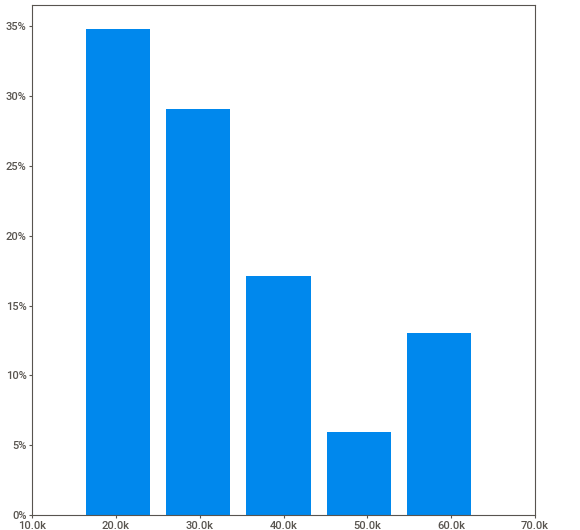
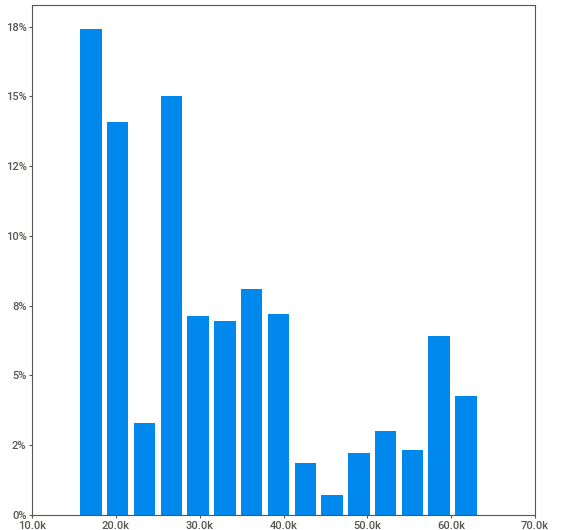
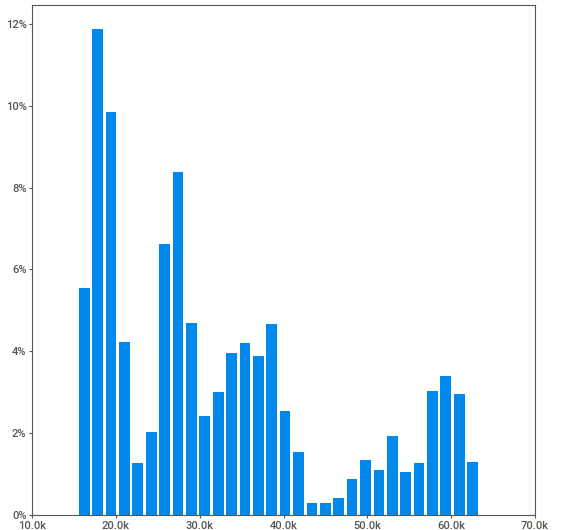
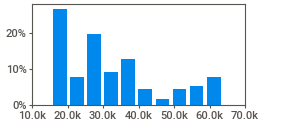
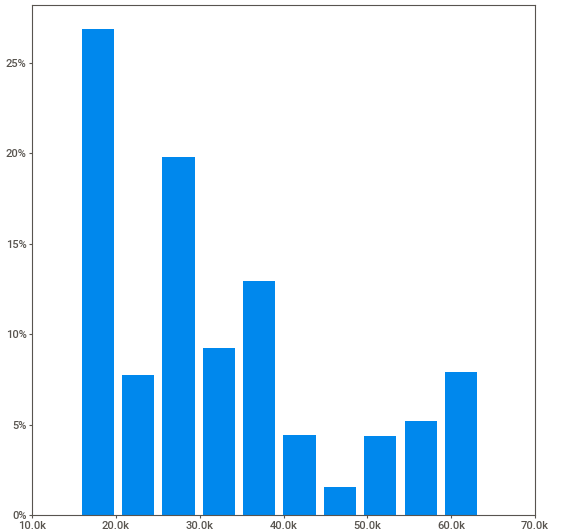
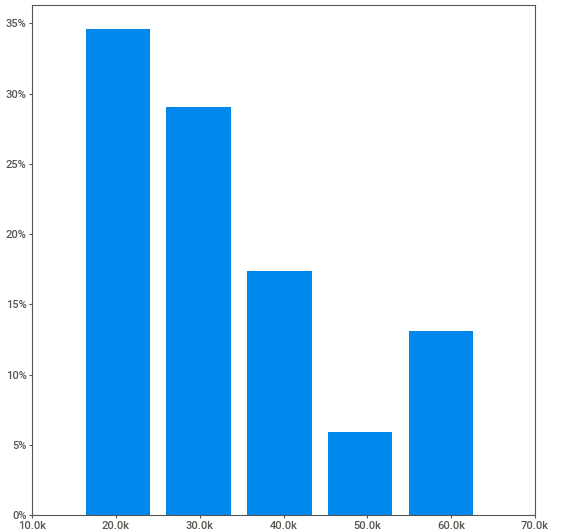
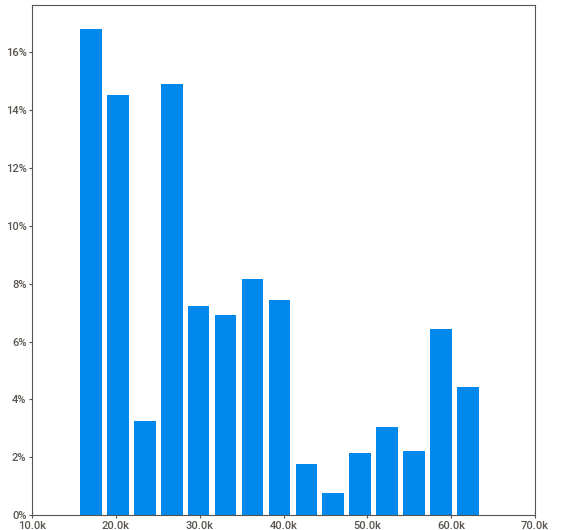
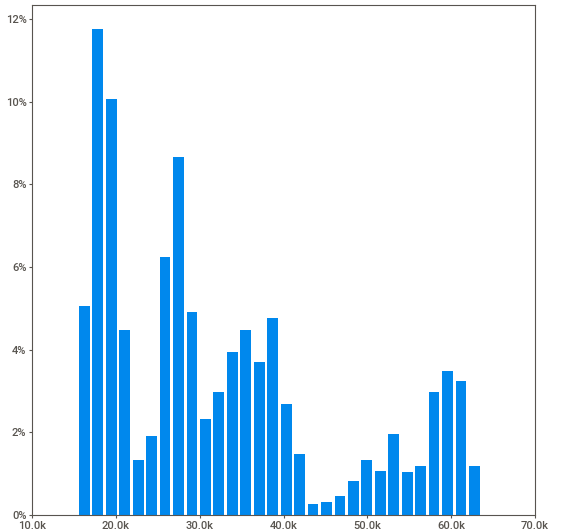
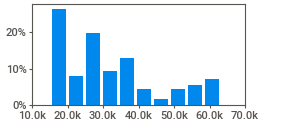
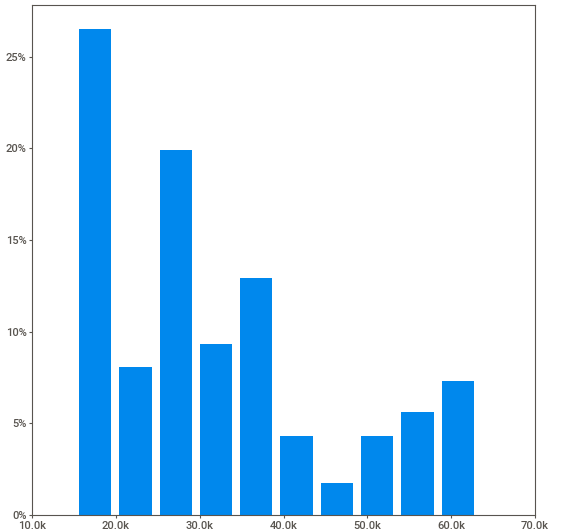
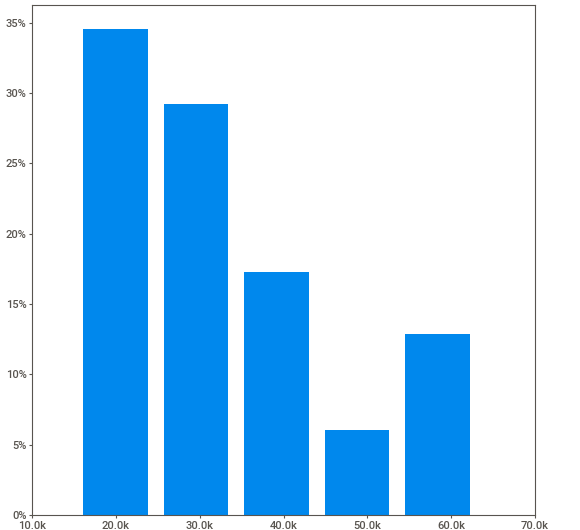
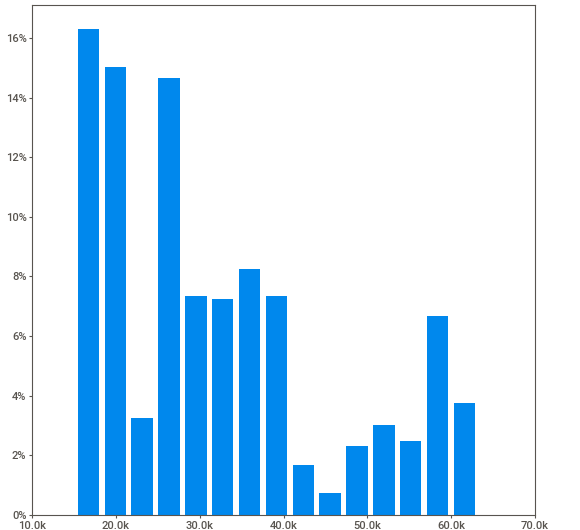
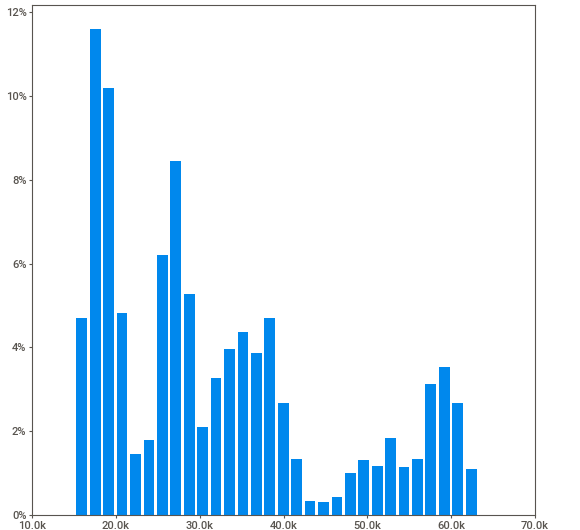
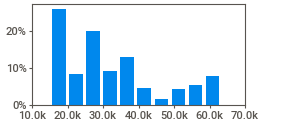
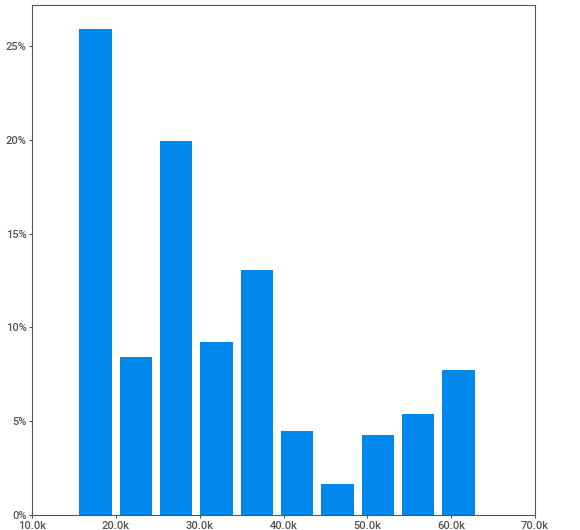
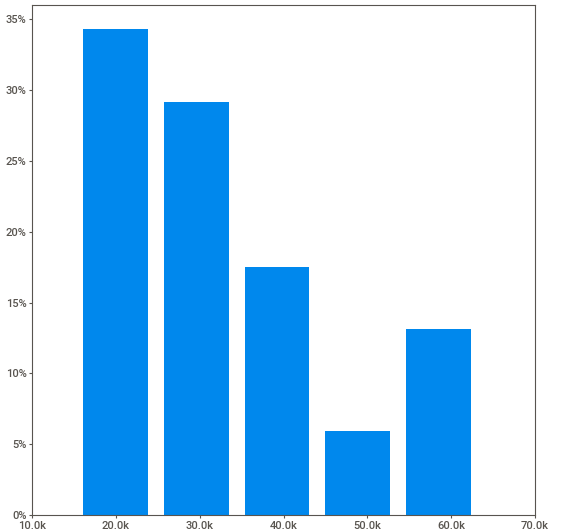
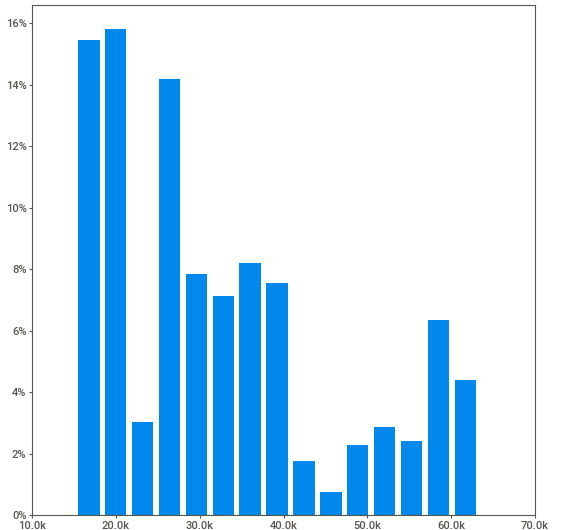
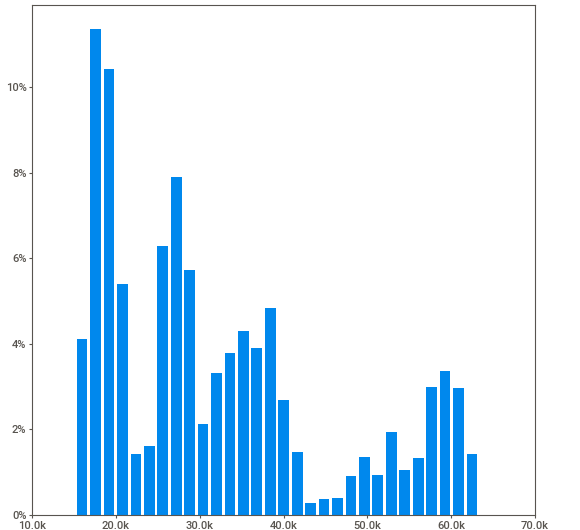
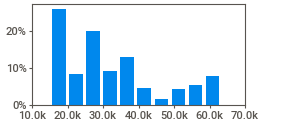
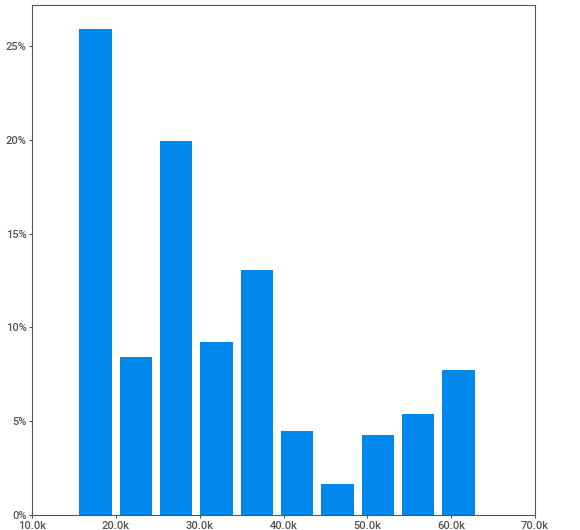
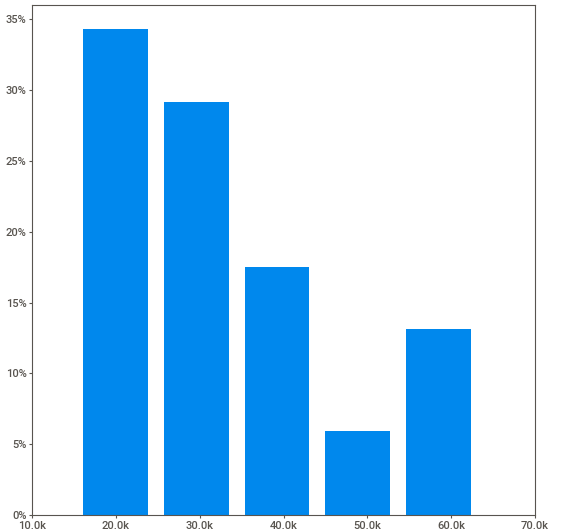
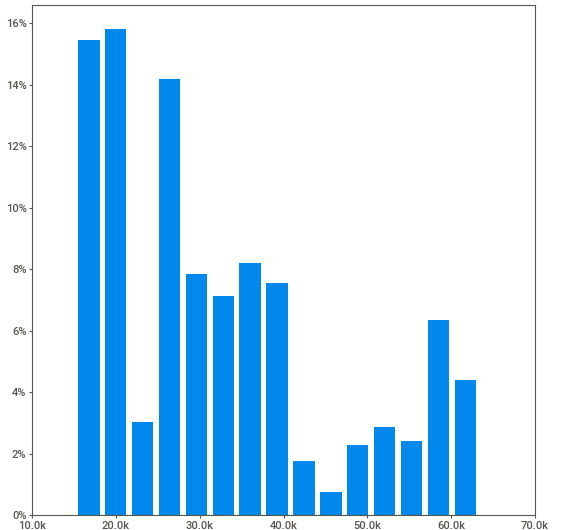
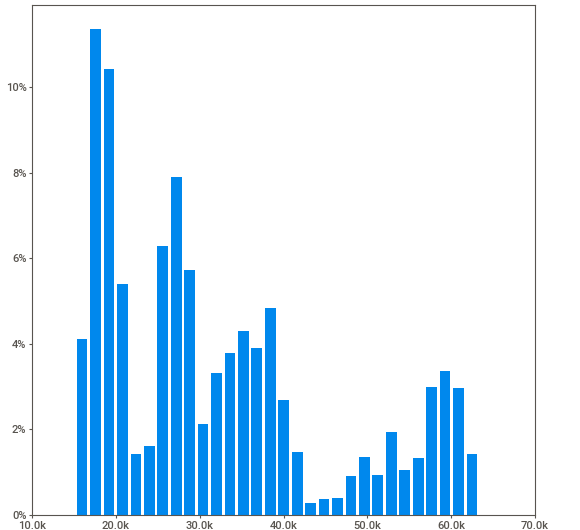
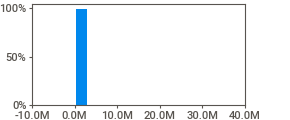
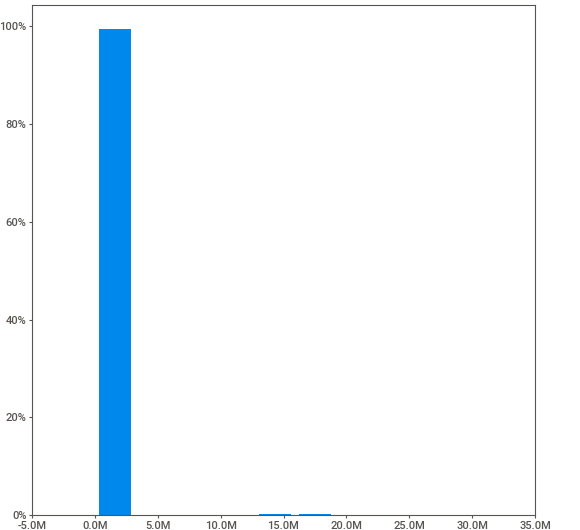
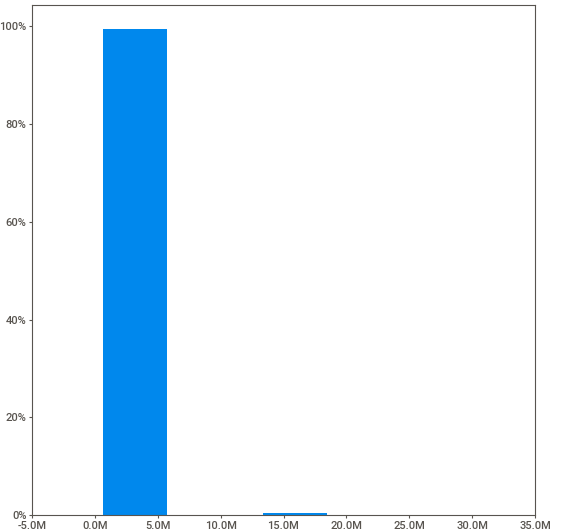
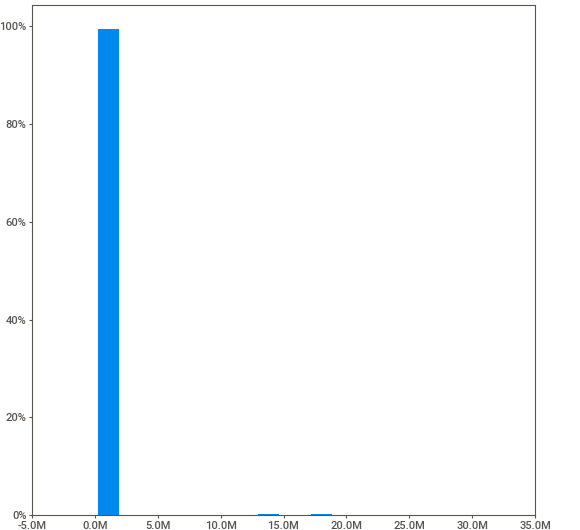
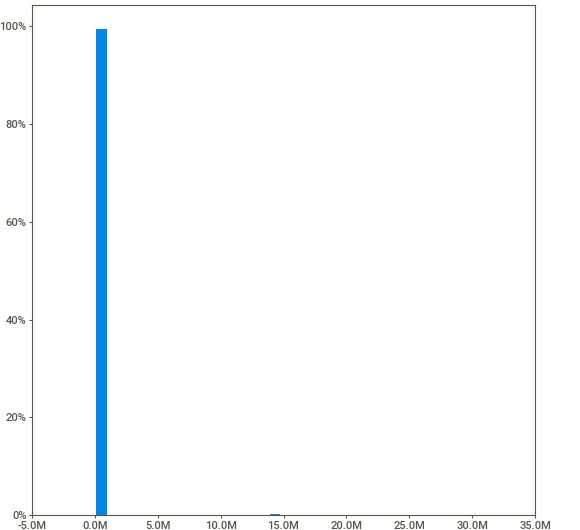
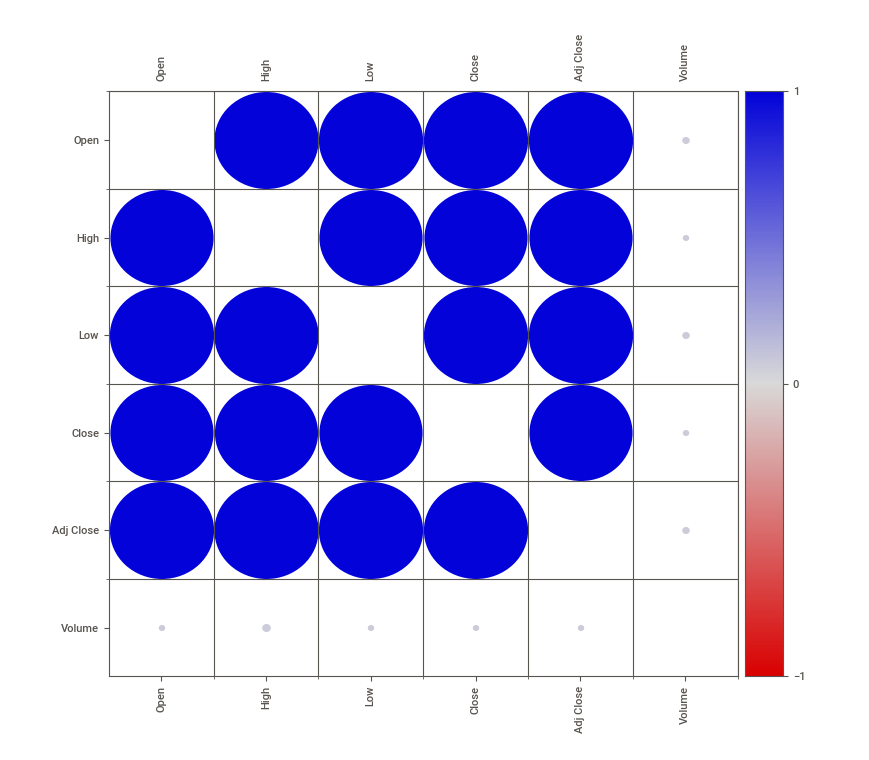
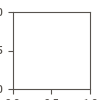

In [39]:
autoEDA = sweetviz.analyze(stock)
autoEDA.show_notebook()

In [40]:
# 'Adj Close' and 'Close' have the same entries
stock=stock.drop(['Adj Close'],axis=1)

In [41]:
stock.head()

,Date,Open,High,Low,Close,Volume
0,2010-01-04,17473.449219,17582.839844,17378.380859,17558.730469,28200
1,2010-01-05,17555.769531,17729.779297,17555.769531,17686.240234,27000
2,2010-01-06,17719.470703,17790.330078,17636.710938,17701.130859,21400
3,2010-01-07,17701.970703,17733.339844,17566.539062,17615.720703,18000
4,2010-01-08,17603.869141,17658.119141,17508.960938,17540.289062,17200


Text(0.5, 1.0, 'Closing Price Graph')

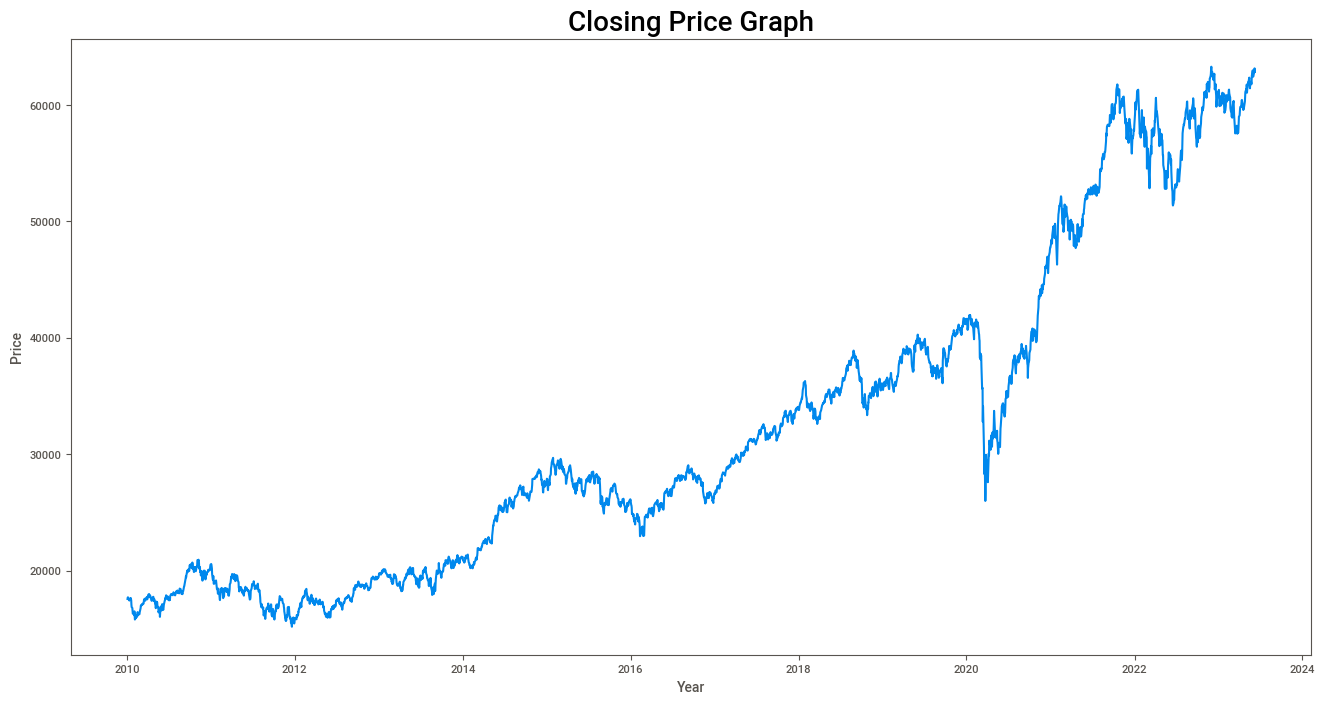

In [42]:
# Closing Graph
plt.figure(figsize=(16,8))
plt.plot(stock['Date'],stock['Close'])
plt.ylabel('Price')
plt.xlabel('Year')
plt.title('Closing Price Graph',fontsize=20)

Text(0.5, 0, 'Year')

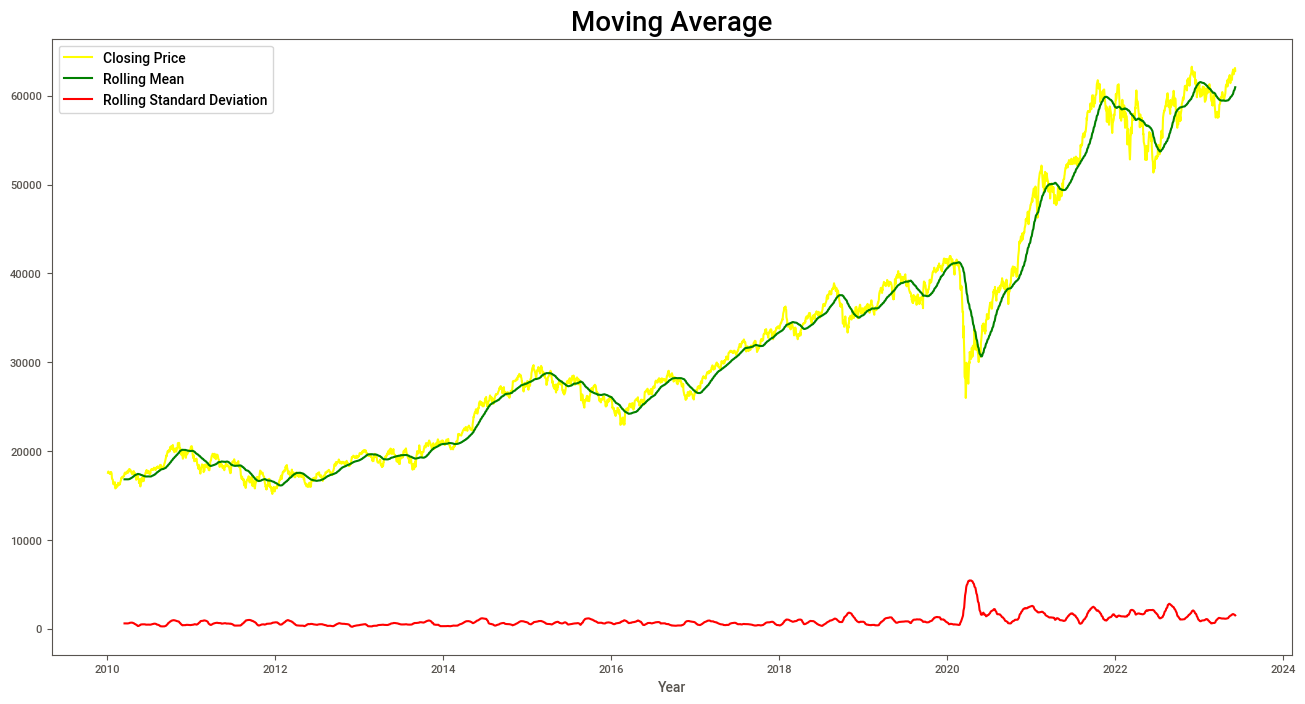

In [43]:
close=stock['Close']

# Finding the rolling mean and rolling standard deviation after every 50 entries
mean=close.rolling(window=50).mean()
std=close.rolling(window=50).std()

# Plotting the Rolling Mean and Rolling Standard Deviation and Closing Price Graphs wrt Date
plt.figure(figsize=(16,8))
plt.plot(stock['Date'], stock['Close'], color='yellow', label='Closing Price')
plt.plot(stock['Date'], mean, color='green', label='Rolling Mean')
plt.plot(stock['Date'], std, color='red', label='Rolling Standard Deviation')

plt.legend()
plt.title("Moving Average",fontsize=20)
plt.xlabel("Year")

Text(0.5, 1.0, 'Returns')

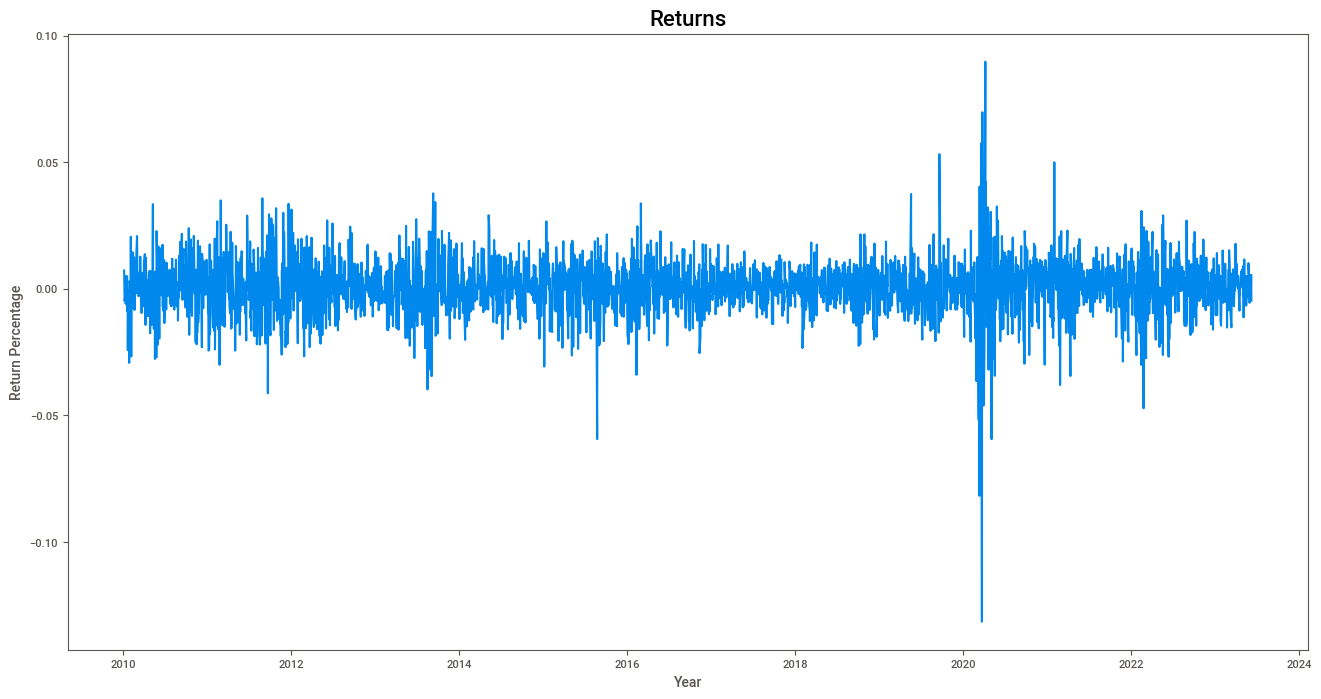

In [44]:
# This calculation represents the percentage change between consecutive values in the close variable
returns = close/close.shift(1)-1
plt.figure(figsize = (16,8))
plt.plot(stock['Date'],returns)
plt.xlabel('Year')
plt.ylabel('Return Percentage')
plt.title('Returns',fontsize=16)

In [45]:
#Stationary Test
def StationaryTest(timeseries):
  rol_mean=timeseries.rolling(20).mean()
  rol_std=timeseries.rolling(20).std()
  plt.figure(figsize=(10,8))
  timeseries.plot(color='red',label='Original')
  rol_mean.plot(color='yellow',label='Rolling Mean')
  rol_std.plot(color='green',label='Rolling Standard Deviation')
  plt.legend()
  plt.title('Rolling Mean and Rolling Standard Deviation',  fontsize = 20)
  print('Results of Dickey Fuller Test')
  result = adfuller(timeseries, autolag = 'AIC')
  labels = ['ADF Test Statistic','p-value','Lags Used','Number of Observations Used']
  for value,label in zip(result, labels):
    print(label+' : '+str(value) )
  if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. \n Timeseries Dataset is stationary")
  else:
    print("Weak evidence against null hypothesis.\n Timeseries Dataset is non-stationary ")

In [46]:
#splitting of data
test=stock[2120:]
train=stock[:2120]       

Results of Dickey Fuller Test
ADF Test Statistic : 0.34765078589284126
p-value : 0.9794281078343905
Lags Used : 1
Number of Observations Used : 2118
Weak evidence against null hypothesis.
 Timeseries Dataset is non-stationary 


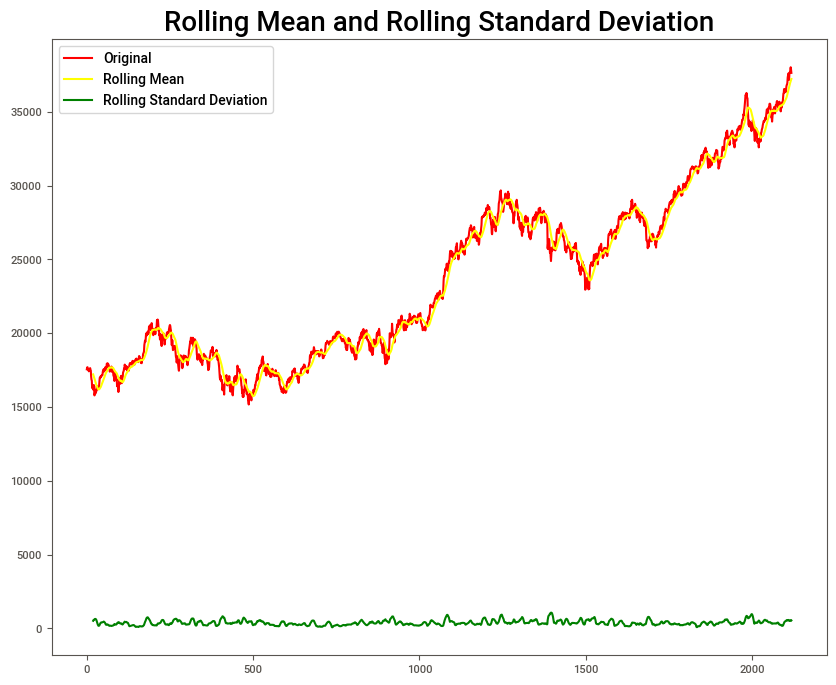

In [47]:
#Stationary Test on Train df closing price
StationaryTest(train['Close'])

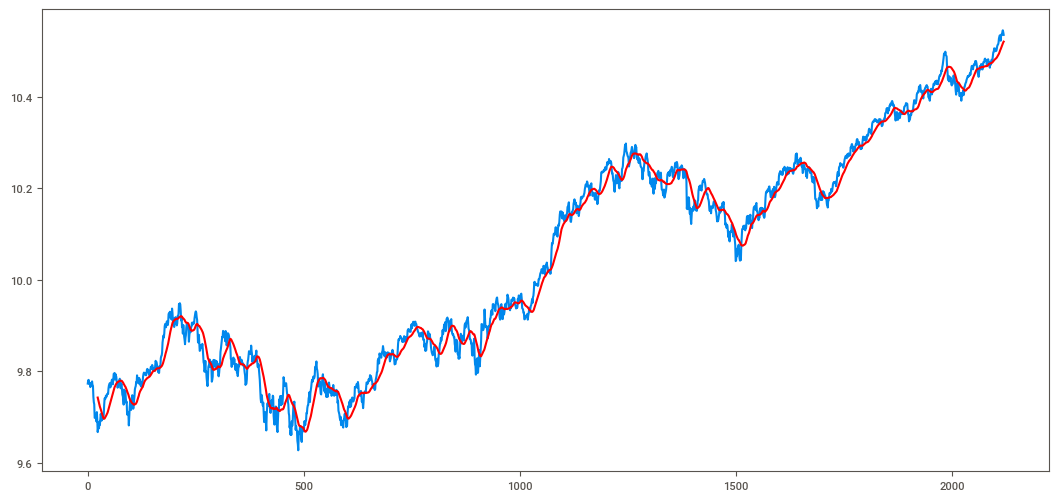

In [48]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])
trmean = train_log.rolling(24).mean() 
plt.figure(figsize = (13,6))
plt.plot(train_log) 
plt.plot(trmean, color = 'red') 

Results of Dickey Fuller Test
ADF Test Statistic : -0.2354319191454196
p-value : 0.9341643266392663
Lags Used : 1
Number of Observations Used : 2118
Weak evidence against null hypothesis.
 Timeseries Dataset is non-stationary 


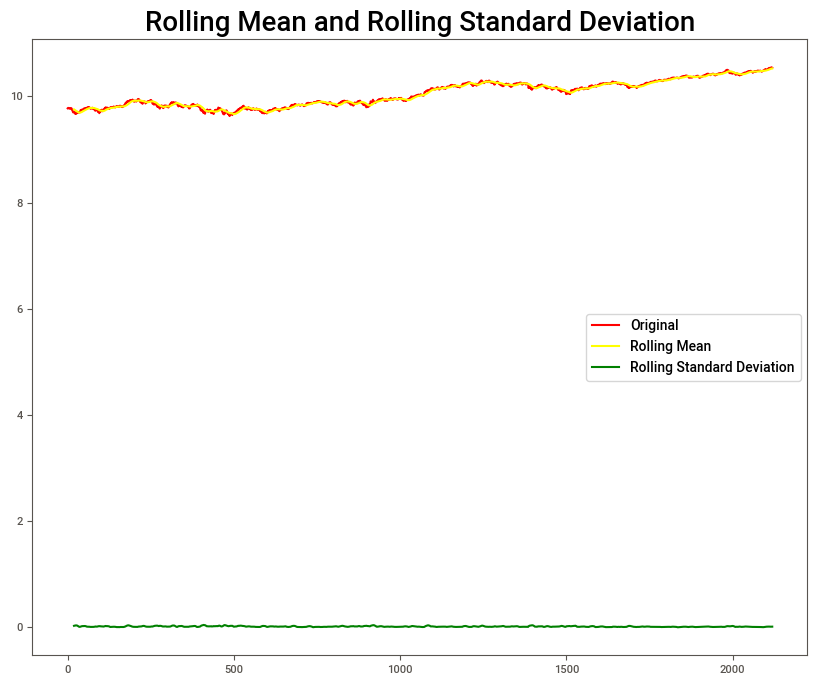

In [49]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)
StationaryTest(train_log)

Results of Dickey Fuller Test
ADF Test Statistic : -9.8998656321569
p-value : 3.3802619909662224e-17
Lags Used : 12
Number of Observations Used : 2084
Strong evidence against the null hypothesis, reject the null hypothesis. 
 Timeseries Dataset is stationary


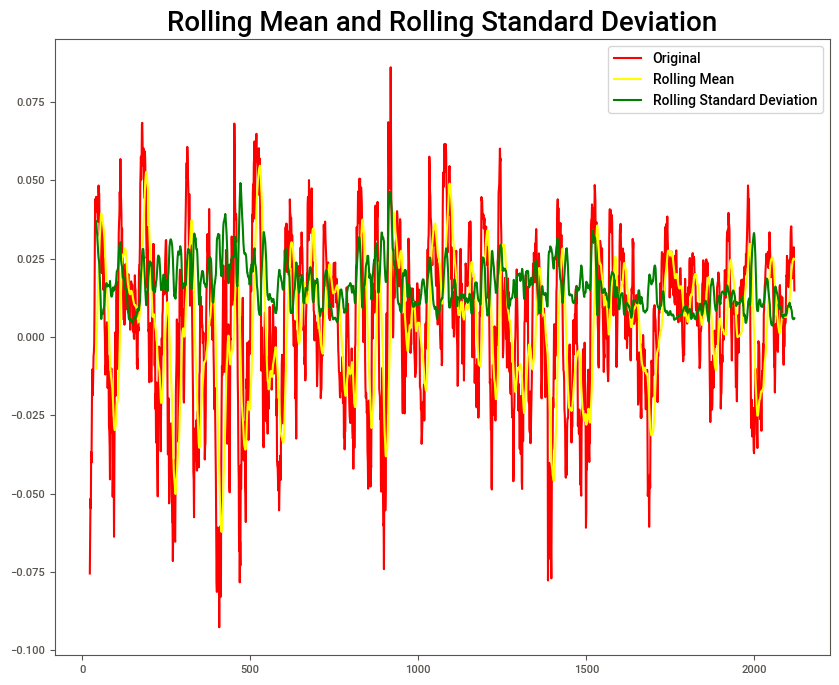

In [50]:
train_log_diff = train_log-trmean
train_log_diff.dropna(inplace = True)
StationaryTest(train_log_diff)

###Training the ARIMA Model

In [51]:
# Creating ARIMA model
model=auto_arima(train_log,trace=True,error_action='ignore',suppress_warnings=True)
model.summary()

# finding predictions from the above obtained model
predictions=model.predict(n_periods= len(test))
predictions=pd.DataFrame(predictions, index=test_log.index, columns=['Prediction'])
predictions

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-13647.650, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13644.001, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13651.592, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13651.741, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13643.064, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13649.764, Time=1.83 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13649.776, Time=1.85 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13648.076, Time=0.97 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13651.157, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 8.703 seconds


,Prediction
2120,10.535902
2121,10.536258
2122,10.536613
2123,10.536969
2124,10.537325
...,...
3298,10.955111
3299,10.955467
3300,10.955822
3301,10.956178


In [52]:
test_log

2120    10.541439
2121    10.536448
2122    10.543969
2123    10.552650
2124    10.552833
          ...    
3298    11.043675
3299    11.047511
3300    11.047597
3301    11.053157
3302    11.048485
Name: Close, Length: 1183, dtype: float64

Text(0, 0.5, 'ACTUAL STOCK PRICE')

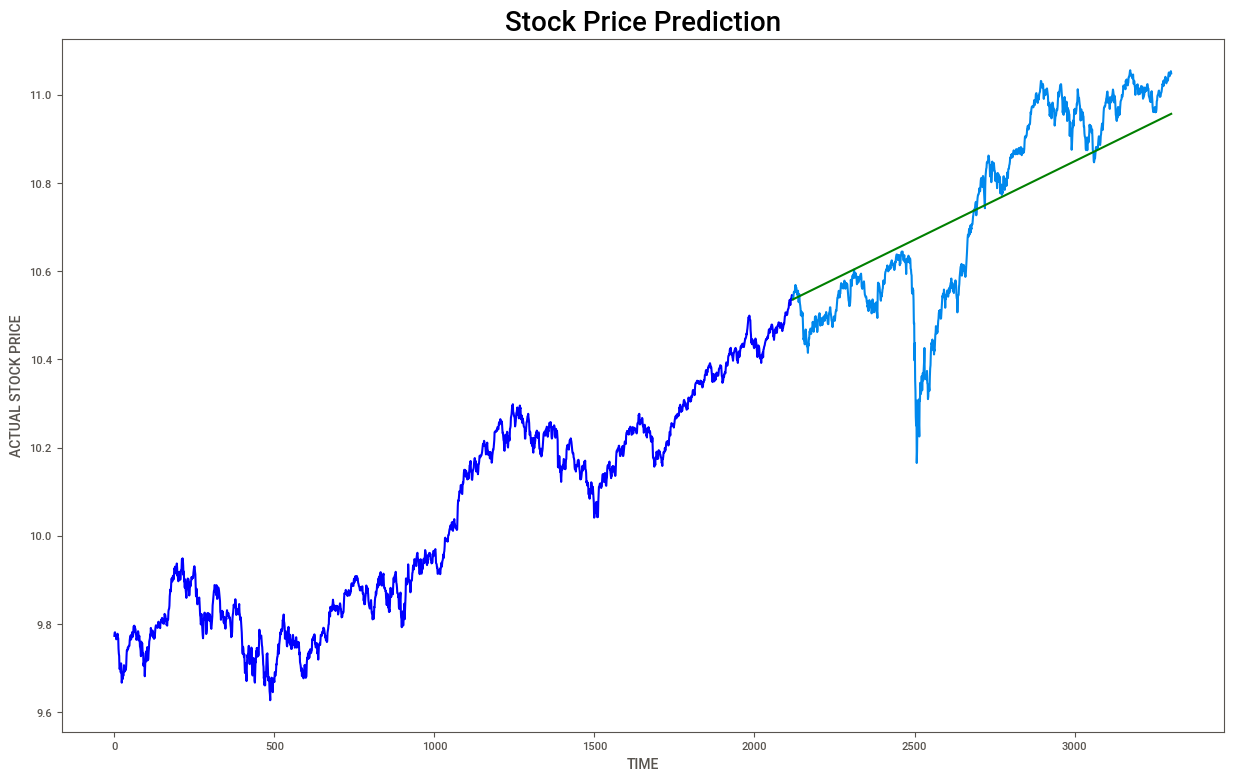

In [53]:
plt.figure(figsize=(15,9))
plt.plot(train_log,label='Train',color='blue')
plt.plot(test_log,label="Test")
plt.plot(predictions,color='green' ,label="Prediction")
plt.title("Stock Price Prediction",fontsize=20)
plt.xlabel("TIME")
plt.ylabel("ACTUAL STOCK PRICE")

In [54]:
#RMSE of ARIMA Model
rmse = np.sqrt(mean_squared_error(test_log,predictions))
print("The Root mean squared error is : ",rmse)

The Root mean squared error is :  0.12442185956819811


###Building the Hybrid Model

####Normalizing the Data

In [58]:
# Merging 'news' and 'stock' into one dataframe
merger=pd.merge(news,stock,how='inner',on='Date')
merger.sample(10)

,News,Date,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Open,High,Low,Close,Volume
2038,Woman s chain snatched in Pkl Bus vandalized n...,2018-04-19,0.378202,0.016932,-1.0000,0.162,0.772,0.066,34403.671875,34478.820312,34358.910156,34427.289062,7600
712,Legend of the Victoria Falls Tragedy mars Chha...,2012-11-20,0.343245,0.044865,-0.9999,0.162,0.742,0.097,18422.689453,18467.910156,18255.689453,18329.320312,6600
1668,Know the reason behind Diwali card parties Acc...,2016-10-21,0.386396,0.066112,-0.9999,0.169,0.736,0.095,28163.410156,28163.410156,27957.919922,28077.179688,8500
2649,Graft case HC relief for official Safety para...,2020-10-16,0.360334,0.054427,-0.9998,0.145,0.759,0.096,39936.609375,40125.710938,39699.421875,39982.980469,11000
2752,ADVT SheMatters Pro Poker Champs Muskan Set...,2021-03-17,0.349404,0.063616,-0.9997,0.107,0.839,0.055,50436.019531,50561.121094,49718.648438,49801.621094,100
2339,Everything you need to know about Coolsculptin...,2019-07-12,0.394098,0.072165,-0.9999,0.154,0.760,0.086,38941.101562,39021.839844,38684.851562,38736.230469,12900
2226,Sporadic rains reported across Saurashtra Kut...,2019-01-23,0.371531,0.072480,-0.9998,0.131,0.803,0.067,36494.121094,36521.468750,36037.898438,36108.468750,14300
190,Mattoo case A chronology of events Another UK...,2010-10-06,0.359912,0.115272,-0.9998,0.152,0.749,0.099,20448.689453,20669.949219,20447.050781,20543.080078,16200
2807,Dweep HC orders release of protesters Gujarat...,2021-06-10,0.350359,0.052968,-0.9999,0.149,0.782,0.069,52143.898438,52346.351562,51957.921875,52300.468750,8600
1834,Xiaomi Redmi 4A up for sale on Amazon Colleges...,2017-06-22,0.358239,0.054683,-0.9999,0.150,0.747,0.103,31351.529297,31522.869141,31255.630859,31290.740234,10200


In [59]:
# Remove all the the columns that are not needed for Building the model
final_df=merger.drop(['Date','News','Open','Volume','High','Low'], axis=1)
final_df

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Close
0,0.450244,0.055160,-0.9994,0.158,0.738,0.104,17558.730469
1,0.418616,0.006579,-0.9996,0.148,0.771,0.081,17686.240234
2,0.431040,0.045747,-0.9996,0.155,0.749,0.096,17701.130859
3,0.404480,0.042532,-0.9997,0.177,0.718,0.105,17615.720703
4,0.383008,0.023707,-0.9998,0.172,0.729,0.100,17540.289062
...,...,...,...,...,...,...,...
3004,0.368342,-0.006025,-1.0000,0.183,0.742,0.075,57362.199219
3005,0.372774,0.060228,-0.9999,0.161,0.740,0.100,57593.488281
3006,0.399341,0.091038,-0.9999,0.161,0.755,0.084,57943.648438
3007,0.335133,0.037703,-0.9999,0.159,0.767,0.074,58683.988281


In [60]:
df=pd.DataFrame(MinMaxScaler().fit_transform(final_df))
df.columns=final_df.columns
df

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Close
0,0.743456,0.375978,0.00030,0.510638,0.395,0.427350,0.051162
1,0.568998,0.085615,0.00020,0.439716,0.560,0.230769,0.053899
2,0.637531,0.319716,0.00020,0.489362,0.450,0.358974,0.054218
3,0.491022,0.300501,0.00015,0.645390,0.295,0.435897,0.052385
4,0.372585,0.187985,0.00010,0.609929,0.350,0.393162,0.050766
...,...,...,...,...,...,...,...
3004,0.291687,0.010281,0.00000,0.687943,0.415,0.179487,0.905487
3005,0.316134,0.406266,0.00005,0.531915,0.405,0.393162,0.910452
3006,0.462677,0.590416,0.00005,0.531915,0.480,0.256410,0.917967
3007,0.108505,0.271637,0.00005,0.517730,0.540,0.170940,0.933858


#### Spliting Data into Train and Test

In [61]:
X = df.drop('Close', axis = 1) # Features Dataframe
y = df['Close'] # Target Vector

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2407, 6), (602, 6), (2407,), (602,))

#### Different Models

In [69]:
# Decision Tree Regressor
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
print('Decision Tree Regressor')
print("Train RMSE :",mean_squared_error(y_train,dt.predict(X_train),squared=False))
print("Test RMSE :",mean_squared_error(y_test,dt.predict(X_test),squared=False))
print("Train Score:",dt.score(X_train, y_train))
print("Test Score:",dt.score(X_test, y_test))

Decision Tree Regressor
Train RMSE : 0.0
Test RMSE : 0.25959812573595664
Train Score: 1.0
Test Score: -0.20740956954402257


In [70]:
# Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
print('Random Forest Regressor')
print("Train RMSE :",mean_squared_error(y_train,rf.predict(X_train),squared=False))
print("Test RMSE :",mean_squared_error(y_test,rf.predict(X_test),squared=False))
print("Train Score:",rf.score(X_train, y_train))
print("Test Score:",rf.score(X_test, y_test))

Random Forest Regressor
Train RMSE : 0.07566735950586392
Test RMSE : 0.19803305812422203
Train Score: 0.9055026206392572
Test Score: 0.2973696637261012


In [71]:
# XGB Regressor
xgb = xgboost.XGBRegressor()
xgb.fit(X_train,y_train)
print('XGB Regressor')
print("Train RMSE :",mean_squared_error(y_train,xgb.predict(X_train),squared=False))
print("Test RMSE :",mean_squared_error(y_test,xgb.predict(X_test),squared=False))
print("Train Score:",xgb.score(X_train, y_train))
print("Test Score:",xgb.score(X_test, y_test))

XGB Regressor
Train RMSE : 0.06644661718727488
Test RMSE : 0.20431555080733793
Train Score: 0.9271300690244009
Test Score: 0.2520813652599597


In [72]:
# LGBM Regressor
lgm = lightgbm.LGBMRegressor()
lgm.fit(X_train,y_train)
print('LGBM Regressor')
print("Train RMSE :",mean_squared_error(y_train,lgm.predict(X_train),squared=False))
print("Test RMSE :",mean_squared_error(y_test,lgm.predict(X_test),squared=False))
print("Train Score:",lgm.score(X_train, y_train))
print("Test Score:",lgm.score(X_test, y_test))

LGBM Regressor
Train RMSE : 0.1337856492496034
Test RMSE : 0.1987191170198665
Train Score: 0.7045923976866073
Test Score: 0.2924928942762698


In [73]:
# AdaBoost Regressor
xgb = AdaBoostRegressor()
xgb.fit(X_train,y_train)
print('AdaBoost Regressor')
print("Train RMSE :",mean_squared_error(y_train,xgb.predict(X_train),squared=False))
print("Test RMSE :",mean_squared_error(y_test,xgb.predict(X_test),squared=False))
print("Train Score:",xgb.score(X_train, y_train))
print("Test Score:",xgb.score(X_test, y_test))

AdaBoost Regressor
Train RMSE : 0.20908901376239727
Test RMSE : 0.2053962700799705
Train Score: 0.2784523197405646
Test Score: 0.24414826580253401


After evaluating all the models we can say that **Random Forest Regressor** has the least Root Mean Squared Error and can be concluded as the best Model of all the 5 models.